In [2]:
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
np.random.seed(1337)

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [5]:
noise = np.random.normal(loc = 0.5, scale = 0.5, size = x_train.shape)
x_train_noisy = x_train + noise


In [6]:
noise = np.random.normal(loc = 0.5, scale = 0.5, size = x_test.shape)
x_test_noisy = x_test + noise


In [8]:
x_train_noisy = np.clip(x_train_noisy, 0., 1,)
x_test_noisy = np.clip(x_test_noisy, 0., 1,)

input_shape = (image_size, image_size, 1)

In [9]:
batch_size = 32
kernel_size = 3
latent_dim = 16
layers_filters = [32, 64]

In [10]:
inputs = Input(shape = input_shape, name = 'encoder_input')
x = inputs

for filters in layers_filters:
    x = Conv2D(filters = filters,
               kernel_size = kernel_size,
               activation = 'relu',
               strides = 2,
               padding = 'same')(x)

In [12]:
shape = K.int_shape(x)

In [13]:
x = Flatten()(x)
latent = Dense(latent_dim, name = 'latent_vector')(x)

In [14]:
encoder = Model(inputs,
                latent,
                name = 'encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 latent_vector (Dense)       (None, 16)                50192     
                                                                 
Total params: 69008 (269.56 KB)
Trainable params: 69008 (269.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
latent_inputs = Input(shape =(latent_dim,), name = 'decoder')
x = Dense(shape[1] *shape[2]* shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [16]:
for filters in layers_filters[::-1]:
    x = Conv2DTranspose(filters = filters,
                        kernel_size = kernel_size,
                        activation = 'relu',
                        strides = 2,
                        padding = 'same')(x)

In [17]:
outputs = Conv2DTranspose(filters = 1,
                          kernel_size = kernel_size,
                          activation = 'sigmoid',
                          padding = 'same',
                          name = 'decoder_output',
                          )(x)

In [18]:
decoder = Model(latent_inputs, outputs, name = 'decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder (InputLayer)        [(None, 16)]              0         
                                                                 
 dense (Dense)               (None, 3136)              53312     
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 decoder_output (Conv2DTran  (None, 28, 28, 1)         289 

In [19]:
autoencoder = Model(inputs, 
                    decoder(encoder (inputs)),
                    name = 'autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                69008     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         108993    
                                                                 
Total params: 178001 (695.32 KB)
Trainable params: 178001 (695.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
autoencoder.compile(loss = 'mse', optimizer='adam')

In [21]:
autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test_noisy, x_test_noisy),
                epochs=10,
                batch_size=batch_size)

Epoch 1/10

1875/1875 [==============================] - 26s 12ms/step - loss: 0.0215 - val_loss: 0.2947
Epoch 2/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0097 - val_loss: 0.2906
Epoch 3/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0086 - val_loss: 0.2880
Epoch 4/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0081 - val_loss: 0.2906
Epoch 5/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0077 - val_loss: 0.2856
Epoch 6/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0074 - val_loss: 0.2881
Epoch 7/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0072 - val_loss: 0.2898
Epoch 8/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0071 - val_loss: 0.2907
Epoch 9/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0069 - val_loss: 0.2931
Epoch 10/10
1875/1875 [==============================] - 32s 17

In [22]:
x_decoded = autoencoder.predict(x_test_noisy)

313/313 [==============================] - 2s 6ms/step


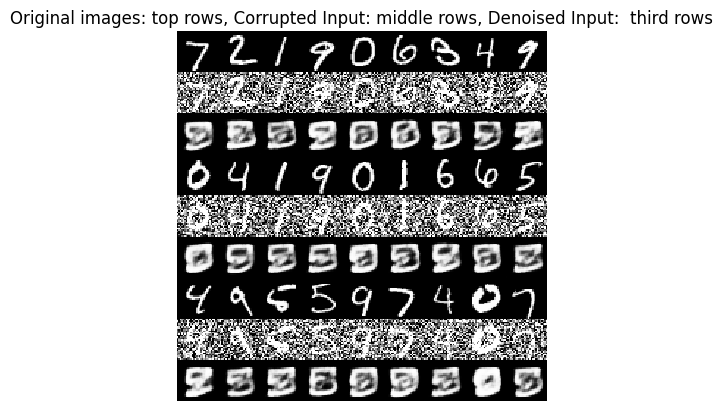

In [23]:
rows, cols = 3, 9
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()